# Assignment 4

In [1]:
import os
import glob
import pickle
import numpy as np
from PIL import Image
from numpy import linalg as LA
import pandas as pd
import cv2
from tqdm import tqdm
from sklearn import svm
import matplotlib.pyplot as plt 
from skimage.io import imread
from skimage.transform import resize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [2]:
print(cv2.__version__)

3.4.2


# get bags of SIFT

In [89]:
# Starter code tranlated from James Hays's code for Computer Vision Fall 2019

#This feature representation is described in the handout, lecture
#materials, and Szeliski chapter 14.

def get_bags_of_sifts(image_paths,des_size,vocab_size):
    
# Use SIFT from Open-CV library refer to the code below for help and update perameters
# to install open-cv use following coomands
# pip install opencv-python==3.4.2.16
# pip install opencv-contrib-python==3.4.2.16    
    
    sift = cv2.xfeatures2d.SIFT_create(des_size) #specify how many maximum descriptors you want in the output 
    with open('vocab'+str(vocab_size )+'.pkl','rb') as f: vocab = pickle.load(f)
    vocab_size=vocab.shape[0]
    KNN = KNeighborsClassifier(n_neighbors=3)
    KNN.fit(vocab,np.arange(0,vocab_size))
    image_feats=np.zeros((len(image_paths),vocab_size))
    for k,img_path in enumerate(image_paths):
        
        im = Image.open(img_path)
        img = np.array(im)
        kp, des = sift.detectAndCompute(img, None)
                
        if des is None:
            continue
#         des=des/LA.norm(des,axis=1).reshape(-1,1)
        bins=KNN.predict(des)
        bag=np.bincount(bins,minlength=vocab_size)

        bag=bag/np.sum(bag)

        image_feats[k]=bag

    
    return image_feats

# image_paths is an N x 1 cell array of strings where each string is an
# image path on the file system.

# This function assumes that 'vocab.pkl' exists and contains an N x 128
# matrix 'vocab' where each row is a kmeans centroid or visual word. This
# matrix is saved to disk rather than passed in a parameter to avoid
# recomputing the vocabulary in every run.

# image_feats is an N x d matrix, where d is the dimensionality of the
# feature representation. In this case, d will equal the number of clusters
# or equivalently the number of entries in each image's histogram
# ('vocab_size') below.

# You will want to construct SIFT features here in the same way you
# did in build_vocabulary function (except for possibly changing the sampling
# rate) and then assign each local feature to its nearest cluster center
# and build a histogram indicating how many times each cluster was used.
# Don't forget to normalize the histogram, or else a larger image with more
# SIFT features will look very different from a smaller version of the same
# image.

#  SIFT_features is a 128 x N matrix of SIFT features
#  note: there are smoothing parameters you can manipulate for sift function





# Build Vocabulary 

In [36]:
# Starter code tranlated from James Hays's code for Computer Vision Fall 2019

#This function will sample SIFT descriptors from the training images,
#cluster them with kmeans, and then return the cluster centers.

def build_vocabulary(image_paths, vocab_size, samples, des_size):
    DES=np.zeros((des_size,128))
    sift = cv2.xfeatures2d.SIFT_create(des_size) #specify how many maximum descriptors you want in the output 
    
    for i,j in tqdm(enumerate(np.random.choice(image_paths.shape[0],samples,replace=False))):

        im = Image.open(image_paths[j])
#         im.thumbnail((128,128), Image.ANTIALIAS) 
        img = np.array(im)

        kp, des = sift.detectAndCompute(img, None)   
        if i==0:
            DES=des
        if des is None:
            continue
            
        des=des/LA.norm(des,axis=1).reshape(-1,1)
        DES=np.concatenate((DES,des),0)
        
    kmeans = KMeans(n_clusters=vocab_size, random_state=0).fit(DES)
    vocab=kmeans.cluster_centers_
 
    return vocab
# The inputs are 'image_paths', a N x 1 cell array of image paths, and
# 'vocab_size' the size of the vocabulary.

# The output 'vocab' should be vocab_size x 128. Each row is a cluster
# centroid / visual word.


# Load images from the training set. To save computation time, you don't
# necessarily need to sample from all images, although it would be better
# to do so. You can randomly sample the descriptors from each image to save
# memory and speed up the clustering. 

# For each loaded image, get some SIFT features. You don't have to get as
# many SIFT features as you will in get_bags_of_sift, because you're only
# trying to get a representative sample here.

# Once you have tens of thousands of SIFT features from many training
# images, cluster them with kmeans. The resulting centroids are now your
# visual word vocabulary.



# get image paths

In [5]:
# Starter code tranlated from James Hays's code for Computer Vision Fall 2019

#This function returns numpy arrays containing the file path for each train
#and test image, with their labels 

def get_image_paths(data_path, categories):
    train_image_paths, train_labels = [], []
    for cat in categories:
        imgs = glob.glob(data_path+'/train/'+cat+'/*.*')
        train_image_paths = train_image_paths + imgs
        train_labels = train_labels + [cat]*len(imgs)

    test_image_paths, test_labels = [], []
    for cat in os.listdir(data_path+'/test/'):
        imgs = glob.glob(data_path+'/test/'+cat+'/*.*')
        test_image_paths = test_image_paths + imgs
        test_labels = test_labels + [cat]*len(imgs)

    return np.array(train_image_paths), np.array(test_image_paths), np.array(train_labels), np.array(test_labels) 




# get tiny Images

In [13]:
# Starter code tranlated from James Hays's code for Computer Vision Fall 2019

#This feature is inspired by the simple tiny images used as features in 
#  80 million tiny images: a large dataset for non-parametric object and
#  scene recognition. A. Torralba, R. Fergus, W. T. Freeman. IEEE
#  Transactions on Pattern Analysis and Machine Intelligence, vol.30(11),
#  pp. 1958-1970, 2008. http://groups.csail.mit.edu/vision/TinyImages/

    

def get_tiny_images(image_paths):
    
    image_feats=[]
    for img_path in (image_paths):
        img=imread(img_path)
        img=resize(img,(16,16))
        img=img.reshape(256)
        img=(img-np.mean(img))
#         img=img/LA.norm(img)
#         img=img/np.max(img)
        image_feats.append(img)
        
    return np.array(image_feats)
# image_paths is an N x 1 cell array of strings where each string is an
#  image path on the file system.
# image_feats is an N x d matrix of resized and then vectorized tiny
#  images. E.g. if the images are resized to 16x16, d would equal 256.

# To build a tiny image feature, simply resize the original image to a very
# small square resolution, e.g. 16x16. You can either resize the images to
# square while ignoring their aspect ratio or you can crop the center
# square portion out of each image. Making the tiny images zero mean and
# unit length (normalizing them) will increase performance modestly.

# suggested functions: imread, imresize

# Nearest Neighbor Classifier

In [7]:
# Starter code tranlated from James Hays's code for Computer Vision Fall 2019

#This function will predict the category for every test image by finding
#the training image with most similar features. Instead of 1 nearest
#neighbor, you can vote based on k nearest neighbors which will increase
#performance (although you need to pick a reasonable value for k).

def nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats):
    KNN = KNeighborsClassifier(n_neighbors=3)

    KNN.fit(train_image_feats,train_labels)
    predicted_categories=[]
    for i in range(test_image_feats.shape[0]):
        predicted_categories.append(KNN.predict(test_image_feats[i].reshape(1,-1))[0])
#     accuracy=KNN.score(test_feats,test_labels)
    
    return np.array(predicted_categories)
# image_feats is an N x d matrix, where d is the dimensionality of the
#  feature representation.
# train_labels is an N x 1 cell array, where each entry is a string
#  indicating the ground truth category for each training image.
# test_image_feats is an M x d matrix, where d is the dimensionality of the
#  feature representation. You can assume M = N unless you've modified the
#  starter code.
# predicted_categories is an M x 1 cell array, where each entry is a string
#  indicating the predicted category for each test image.

# SVM Classifier

In [8]:
# Starter code tranlated from James Hays's code for Computer Vision Fall 2019

#This function will train a linear SVM for every category (i.e. one vs all)
#and then use the learned linear classifiers to predict the category of
#every test image. Every test feature will be evaluated with all 15 SVMs
#and the most confident SVM will "win". Confidence, or distance from the
#margin, is W*X + B where '*' is the inner product or dot product and W and
#B are the learned hyperplane parameters.

def svm_classify(train_image_feats, train_labels, test_image_feats):
    
    
    categories = list(set(train_labels))
    num_categories = len(categories)
    
    #make an SVM classifier
    clf = svm.LinearSVC()

    #fit on the training data
    #you need to put your own array names here
    clf.fit(train_image_feats, train_labels)
    
    predicted_categories=[]
    for i in range(test_image_feats.shape[0]):
        predicted_categories.append(clf.predict(test_image_feats[i].reshape(1,-1)))
            
#     accuracy=clf.score(test_image_feats,test_labels)
    return np.array(predicted_categories)
# image_feats is an N x d matrix, where d is the dimensionality of the
#  feature representation.
# train_labels is an N x 1 cell array, where each entry is a string
#  indicating the ground truth category for each training image.
# test_image_feats is an M x d matrix, where d is the dimensionality of the
#  feature representation. You can assume M = N unless you've modified the
#  starter code.
# predicted_categories is an M x 1 cell array, where each entry is a string
#  indicating the predicted category for each test image.


# Display results

In [70]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    fig.set_size_inches(5, 5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def perf_measure(y_actual, y_hat):
    TP, FP, TN, FN = 0, 0, 0, 0
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
            TP += 1
        elif y_hat[i]==1 and y_actual[i]!=y_hat[i]:
            FP += 1
        elif y_actual[i]==y_hat[i]==0:
            TN += 1
        elif y_hat[i]==0 and y_actual[i]!=y_hat[i]:
            FN += 1

    return [TP, FP, TN, FN]


def display_results(test_labels, categories, predicted_categories):
    df = pd.DataFrame(columns= ['Category']+list(categories))

    cols = ['Category']+['TP', 'FP', 'TN', 'FN']
    df = pd.DataFrame(columns= cols)
    for el in categories:
        temp_y_test = (test_labels == el).astype(int)
        temp_preds = (predicted_categories == el).astype(int)
        row = [el]+ perf_measure(temp_y_test, temp_preds)
        df = df.append(pd.Series(row, index=cols), ignore_index=True)
    print(df, '\n\n')

    for i in range(len(categories)):
        test_labels[test_labels==categories[i]] = i
        predicted_categories[predicted_categories==categories[i]] = i
    test_labels, predicted_categories = test_labels.astype(int), predicted_categories.astype(int)

    class_names=np.array(categories)
    plot_confusion_matrix(test_labels, predicted_categories, classes=class_names)
    
    fig = plt.gcf()
    fig.set_size_inches(5, 5)

    fig.show()
    
    acc = accuracy_score(y_pred=predicted_categories, y_true=test_labels) #you need to put your own array names here
    print('Accuracy: ', acc)
    
    return

Getting paths and labels for all train and test data

Using bag of sift representation for images

Using nearest neighbor classifier to predict test set categories

        Category   TP  FP   TN   FN
0        Kitchen    0  30  675    0
1          Store    0   7  698    0
2        Bedroom   44  36  553   72
3     LivingRoom    0  15  690    0
4         Office    0  11  694    0
5     Industrial    0  41  664    0
6         Suburb    0  16  689    0
7     InsideCity    0  11  694    0
8   TallBuilding    0   3  702    0
9         Street    0  13  692    0
10       Highway   55  44  560   46
11   OpenCountry    0  32  673    0
12         Coast  105  17  428  155
13      Mountain    0  44  661    0
14        Forest  162  19  458   66 


Confusion matrix, without normalization
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 22   2  44  11   9   6   1   3   1   1   7   4   2   2   1]
 [  0   0   0   0   0   0  

/home/junaid/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:90: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Accuracy:  0.5191489361702127


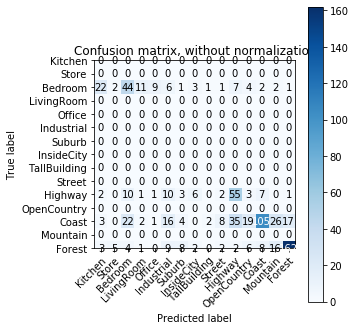

In [92]:
# Starter code tranlated from James Hays's code for Computer Vision Fall 2019

# All of your code will be in "Step 1" and "Step 2", although you can
# modify other parameters in the starter code.

## Step 0: Set up parameters, category list, and image paths.

#For this Assignment, you will need to report performance for three
#combinations of features / classifiers. It is suggested you code them in
#this order, as well:
# 1) Tiny image features and nearest neighbor classifier
# 2) Bag of sift features and nearest neighbor classifier
# 3) Bag of sift features and linear SVM classifier

#The starter code is initialized to 'placeholder' just so that the starter
#code does not crash when run unmodified and you can get a preview of how
#results are presented.

# FEATURE = 'tiny image'
# FEATURE = 'bag of sift'
FEATURE = 'bag of sift'
calc_vocab=False
des_size =200
samples= 1500
vocab_size = 400
# CLASSIFIER = 'nearest neighbor'
# CLASSIFIER = 'support vector machine'
CLASSIFIER = 'nearest neighbor'

data_path = '../data/'
# data_path = '/home/junaid/Desktop/Third/Computer  Vision/assignments/Assignment_4_bag_of_words/4_bag_of_words/data'

#This is the list of categories / directories to use. The categories are
#somewhat sorted by similarity so that the confusion matrix looks more
#structured (indoor and then urban and then rural).

categories = np.array(['Kitchen', 'Store', 'Bedroom', 'LivingRoom', 'Office',
              'Industrial', 'Suburb', 'InsideCity', 'TallBuilding', 'Street',
              'Highway', 'OpenCountry', 'Coast', 'Mountain', 'Forest'])
   
# #This list of shortened category names is used later for visualization.
abbr_categories = np.array(['Kit', 'Sto', 'Bed', 'Liv', 'Off', 'Ind', 'Sub',
                   'Cty', 'Bld', 'St', 'HW', 'OC', 'Cst', 'Mnt', 'For'])
    

#This function returns cell arrays containing the file path for each train
#and test image, as well as cell arrays with the label of each train and
#test image. By default all four of these arrays will be 1500x1 where each
#entry is a char array (or string).
print('Getting paths and labels for all train and test data\n')
train_image_paths, test_image_paths, train_labels, test_labels = get_image_paths(data_path, categories)


#   train_image_paths  1500x1   cell      
#   test_image_paths   705x1    cell           
#   train_labels       1500x1   cell         
#   test_labels        705x1    cell          

## Step 1: Represent each image with the appropriate feature
# Each function to construct features should return an N x d matrix, where
# N is the number of paths passed to the function and d is the 
# dimensionality of each image representation. See the starter code for
# each function for more details.

print("Using",FEATURE, "representation for images\n")


if(FEATURE == 'tiny image'):
    # Code get_tiny_images function above 1st
    train_image_feats = get_tiny_images(train_image_paths);
    test_image_feats  = get_tiny_images(test_image_paths);
    pass
elif(FEATURE == 'bag of sift'):
    # Code build_vocabulary function 1st
    if((not os.path.exists('./vocab.pkl')) or calc_vocab):
        print('No existing visual word vocabulary found. Computing one from training images\n')
         #Larger values will work better (to a point) but be slower to compute
        vocab=build_vocabulary(train_image_paths, vocab_size=vocab_size , samples=samples, des_size=des_size)
        with open('vocab'+str(vocab_size )+'.pkl','wb') as f: pickle.dump(vocab, f)
     # Code get_bags_of_sifts function
    train_image_feats = get_bags_of_sifts(train_image_paths,des_size=des_size,vocab_size=vocab_size)
    test_image_feats  = get_bags_of_sifts(test_image_paths,des_size=des_size,vocab_size=vocab_size)
        
elif(FEATURE == 'placeholder'):
    train_image_feats = []
    test_image_feats = []
        
else:
    print('Unknown feature type')


# You should avoid recomputing the features while debugging the classifiers
# so you need to 'save' and 'load' the features using pickle library

## Step 2: Classify each test image by training and using the appropriate classifier
#  to classify test features should return an N x 1 cell array,
# where N is the number of test cases and each entry is a string indicating
# the predicted category for each test image. Each entry in
# 'predicted_categories' must be one of the 15 strings in 'categories',
# 'train_labels', and 'test_labels'. See the starter code for each function
# for more details.

print('Using', CLASSIFIER, 'classifier to predict test set categories\n')

if(CLASSIFIER == 'nearest neighbor'):
    # Code nearest_neighbor_classify function above
    predicted_categories = nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats)
        
elif(CLASSIFIER == 'support vector machine'):
    # Code svm_classify function above
    predicted_categories = svm_classify(train_image_feats, train_labels, test_image_feats)
        
elif(CLASSIFIER == 'placeholder'):
    # The placeholder classifier simply predicts a random category for every test case
    predicted_categories = np.random.permutation(test_labels)
        
else:
     print('Unknown classifier type')



## Step 3: Build a confusion matrix and score the recognition system
# You do not need to code anything in this section. 

# If we wanted to evaluate our recognition method properly we would train
# and test on many random splits of the data. You are not required to do so
# for this project.

# This function will plot confusion matrix and accuracy of your model
display_results(test_labels, categories, predicted_categories)

# Interpreting your performance with 100 training examples per category:
#  accuracy  =   0 -> Your code is broken (probably not the classifier's
#                     fault! A classifier would have to be amazing to
#                     perform this badly).
#  accuracy ~= .07 -> Your performance is chance. Something is broken or
#                     you ran the starter code unchanged.
#  accuracy ~= .20 -> Rough performance with tiny images and nearest
#                     neighbor classifier. Performance goes up a few
#                     percentage points with K-NN instead of 1-NN.
#  accuracy ~= .20 -> Rough performance with tiny images and linear SVM
#                     classifier. The linear classifiers will have a lot of
#                     trouble trying to separate the classes and may be
#                     unstable (e.g. everything classified to one category)
#  accuracy ~= .50 -> Rough performance with bag of SIFT and nearest
#                     neighbor classifier. Can reach .60 with K-NN and
#                     different distance metrics.
#  accuracy ~= .60 -> You've gotten things roughly correct with bag of
#                     SIFT and a linear SVM classifier.
#  accuracy >= .70 -> You've also tuned your parameters well. E.g. number
#                     of clusters, SVM regularization, number of patches
#                     sampled when building vocabulary, size and step for
#                     dense SIFT features.
#  accuracy >= .80 -> You've added in spatial information somehow or you've
#                     added additional, complementary image features. This
#                     represents state of the art in Lazebnik et al 2006.
#  accuracy >= .85 -> You've done extremely well. This is the state of the
#                     art in the 2010 SUN database paper from fusing many 
#                     features. Don't trust this number unless you actually
#                     measure many random splits.
#  accuracy >= .90 -> You used modern deep features trained on much larger
#                     image databases.
#  accuracy >= .96 -> You can beat a human at this task. This isn't a
#                     realistic number. Some accuracy calculation is broken
#                     or your classifier is cheating and seeing the test
#                     labels.
